In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get column names for tables
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

print('--------')
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]
last_date

'2017-08-23'

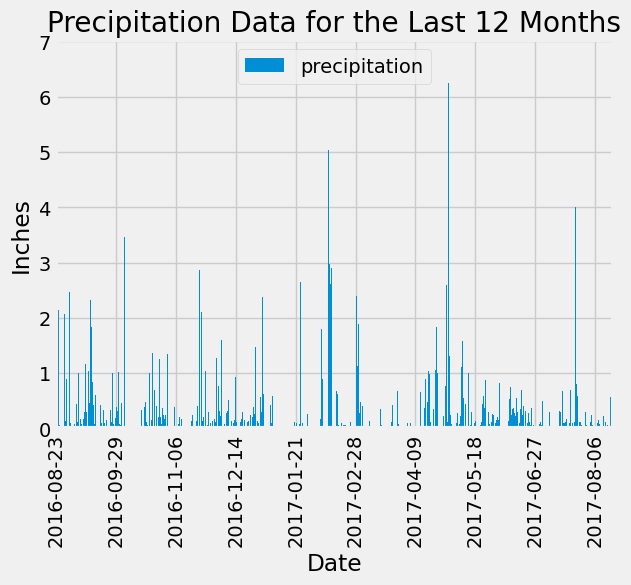

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).order_by(Measurement.date).all()
data
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns=['date', 'precipitation'])
df
# Sort the dataframe by date
df_sorted = df.sort_values(by='date')


# Use Pandas Plotting with Matplotlib to plot the data 
ax = df_sorted.plot(x='date', y='precipitation', rot=90, kind='bar', width=2) 
plt.xlabel("Date") 
plt.ylabel("Inches") 
plt.title("Precipitation Data for the Last 12 Months") 
# Reduce the number of x-axis labels 
ax.set_xticks(ax.get_xticks()[::240]) 
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_sorted['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
station_count

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_measurements = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in station_measurements:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station = station_measurements[0][0]
top_station

top_station_data = session.query(Measurement.tobs).filter(Measurement.station == top_station).all()
temperatures = [row[0] for row in top_station_data]

min_value = min(temperatures)
max_value = max(temperatures)
avg_value = (sum(temperatures)/len(temperatures))
print(f"Min: {min_value}, Max: {max_value}, Avg: {avg_value}")

Min: 54.0, Max: 85.0, Avg: 71.66378066378067


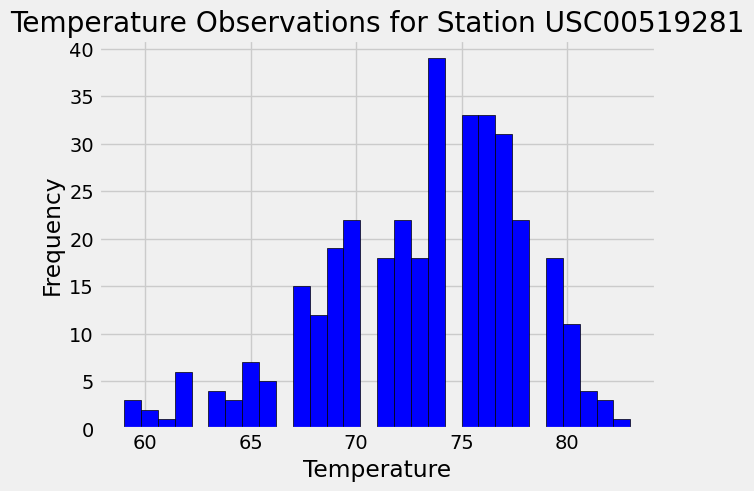

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= prev_year).\
filter(Measurement.station == top_station).order_by(Measurement.date).all()

temperatures = [row.tobs for row in data]


plt.hist(temperatures, bins=30, color='blue', edgecolor='black')
plt.title(f'Temperature Observations for Station {top_station}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
